In [2]:
!pip install torchsampler
!pip install xgboost
!pip install torchmetrics
!pip install pytorch_lightning
!pip install optuna
!pip install memory_profiler

In [3]:
import cv2
from skimage import feature

def rgb_to_cielab(image):
    #print(np.shape(image))
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

def rgb_to_cieluv(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

def rgb_to_hsv(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
def rgb_to_cieYCrCb(image):
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

def extract_color_features(image):
    features = []
    for color_space_func in [rgb_to_cielab, rgb_to_cieYCrCb, rgb_to_hsv]:
        transformed_image = color_space_func(image)
        mean = np.mean(transformed_image, axis=(0, 1))
        std = np.std(transformed_image, axis=(0, 1))
        features.extend(mean)
        features.extend(std)
    return features

def extract_lbp(image):
   image = np.transpose(image, (1, 2, 0))
   image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
   sample_detailed = feature.local_binary_pattern(image, P=8, R=1, method='uniform')
   sample_broad = feature.local_binary_pattern(image, P=24, R=3, method='uniform')
   hist_detailed = np.histogram(sample_detailed, bins=10)[0]
   hist_broad = np.histogram(sample_broad, bins=26)[0]
   return  np.concatenate([hist_detailed, hist_broad])

def extract_color_palette(image, num_colors=5):
    if len(image.shape) == 3 and image.shape[2] == 3:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image_rgb = image
    pixels = image_rgb.reshape((-1, 3))
    pixels = np.float32(pixels)
    _, labels, centers = cv2.kmeans(pixels, num_colors, None,
                                    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                                    attempts=10,
                                    flags=cv2.KMEANS_RANDOM_CENTERS)
   # print(centers)
    centroids = centers.flatten().tolist()

    return  centroids

def extract_features(model, train_loader):
  features = []
  labels_ = []
  map_img_feature = {}
  for inputs, labels in train_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      feature = model(inputs)
      #print(feature)

      #feature = feature.mean((2,3)).squeeze()
      transformer_feature = feature.squeeze(0).detach().cpu().numpy()

      print(f"transformer_feature - {np.shape(transformer_feature)}")
      color_feature = extract_color_features(inputs.squeeze().detach().cpu().numpy())
      color_palette = extract_color_palette(inputs.squeeze().detach().cpu().numpy(), num_colors=15)
      lbp_features = extract_lbp(inputs.squeeze().detach().cpu().numpy())
      concatenated_vector = np.concatenate((transformer_feature, color_feature, color_palette, lbp_features))
      print(f"concated vector  - {np.shape(concatenated_vector)}")
      features.append(concatenated_vector)
      # no clustering
      # concatenated_vector = np.concatenate((cnn_feature, color_feature))
      # features.append(concatenated_vector)
      labels_.append(labels.cpu().numpy())
      print("----------------------------------")

  return features, labels_, map_img_feature


In [6]:
import torch
import torch.nn as nn
import timm

class ViTFeatureExtractor(nn.Module):
    def __init__(self, model_name: str = "vit_base_patch16_224", layer_name: str = "blocks.6", extract_cls: bool = True):
        """
        Extract features from a specified layer of a Vision Transformer (ViT).

        :param model_name: The name of the ViT model from `timm`
        :param layer_name: The layer from which to extract features (e.g., "blocks.6")
        :param extract_cls: If True, return only the CLS token feature
        """
        super(ViTFeatureExtractor, self).__init__()

        # Load pretrained ViT model from timm
        self.model = timm.create_model(model_name, pretrained=True)
        self.layer_name = layer_name
        self.extract_cls = extract_cls  # Flag for CLS token extraction
        self.activations = dict()

        # Define hook function
        def hook(module, input, output):
            self.activations[layer_name] = output  # Store output of the hooked layer

        # Register hook on the specified layer
        layer = dict(self.model.named_modules())[layer_name]
        layer.register_forward_hook(hook)

    def forward(self, x):
        """
        Forward pass through the ViT model, capturing activations from the specified layer.

        :param x: Input image tensor of shape (batch_size, 3, 224, 224)
        :return: Extracted features from the specified layer (CLS token if extract_cls=True)
        """
        _ = self.model(x)  # Run forward pass
        features = self.activations[self.layer_name]  # Extracted features

        if self.extract_cls:
            return features[:, 0]  # Extract only CLS token (first token)
        return features  # Return full features

device = 'cpu'

model = ViTFeatureExtractor().to(device)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 56.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.4/481.4 kB 150.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 150.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
data = ArtStyleDataset('faces2', transform)

dataset = dl.data_load(data)
train_data , train_labels,map_img_feature = extract_features(model, dataset)
dl.save_pickle(train_data,train_labels, " trans_faces_NEW")

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

transformer_feature - (768,)
concated vector  - (867,)
----------------------------------


/opt/conda/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transformer_feature - (768,)
concated vector  - (867,)
----------------------------------
transforme

In [7]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e
from sklearn.model_selection import StratifiedKFold, cross_val_score


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
device = 'cpu'

num_classes = 8


Python 3.11.6
/usr/bin/sh: line 1: nvcc: command not found
Source files will be saved in "/tmp/tmp2ci8kxyp".


In [2]:
!pip install opencv-python-headless


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 18.7 MB/s eta 0:00:0000:010:01m


In [3]:
!pip install scikit-learn
!pip install matplotlib
! pip install imageio
! pip install cv2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 84.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 73.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 19.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 10.4 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import  numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import psutil
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
)
def precision_recall_draw(y_true, y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def roc_draw(y_true, y_score):
  from sklearn.preprocessing import label_binarize
  plt.figure(figsize=(15, 10))
  y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names))])


  for i, class_name in enumerate(class_names):
     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()


def evaluate_model(y_true, y_pred, y_pred_proba):
    report_dict = classification_report(y_pred, y_true, target_names=class_names, output_dict=True)
    metrics_df2 = pd.DataFrame(report_dict).transpose()
    print(metrics_df2)
    print("-----------------------------------------------------------------------------------------------------------")

    precision_recall_draw(y_true, y_pred_proba)
    roc_draw(y_true, y_pred_proba)
    cm =confusion_matrix(y_true, y_pred, normalize = 'true')
    #cm_percent_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    
    disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Not normalized Confusion Matrix")
    plt.show()

In [15]:
! pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 18.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 32.7 MB/s eta 0:00:00


In [ ]:
X_train shape: (14804, 1)
y_train shape: (14804, 867)

1. Transformer Parameter Search

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                       precision    recall  f1-score      support
Baroque                 0.908019  0.897436  0.902696   858.000000
Cubism                  0.804348  0.860465  0.831461    43.000000
Fauvism                 0.807692  0.913043  0.857143    23.000000
Impressionism           0.938650  0.902655  0.920301   678.000000
Naive_Art_Primitivism   0.852941  0.884146  0.868263   164.000000
Pointillism             0.733333  0.846154  0.785714    13.000000
Rococo                  0.791328  0.851312  0.820225   343.000000
Ukiyo_e                 1.000000  0.826087  0.904762    23.000000
accuracy                0.889044  0.889044  0.889044     0.889044
macro avg               0.854539  0.872662  0.861321  2145.000000
weighted avg            0.891604  0.889044  0.889837  2145.000000
-----------------------------------------------------------------------------------------------------------


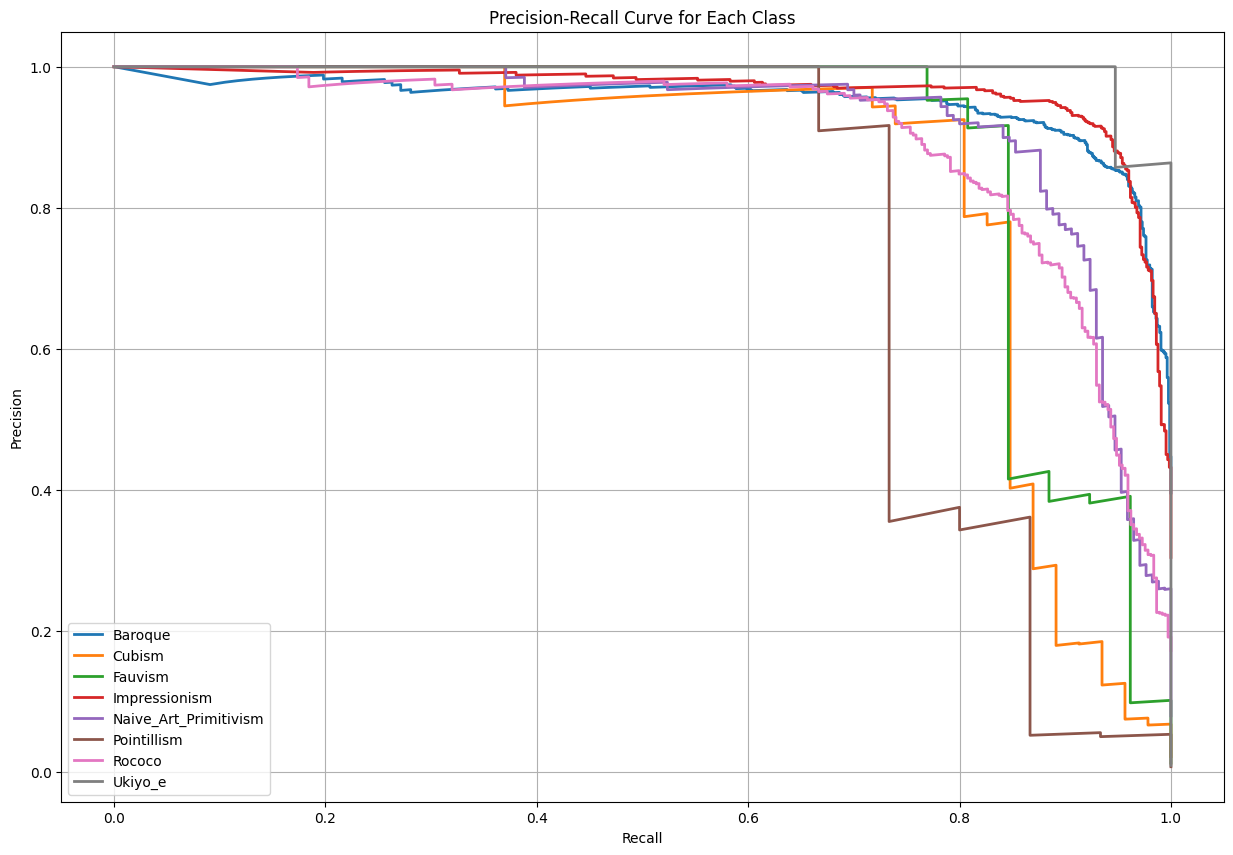

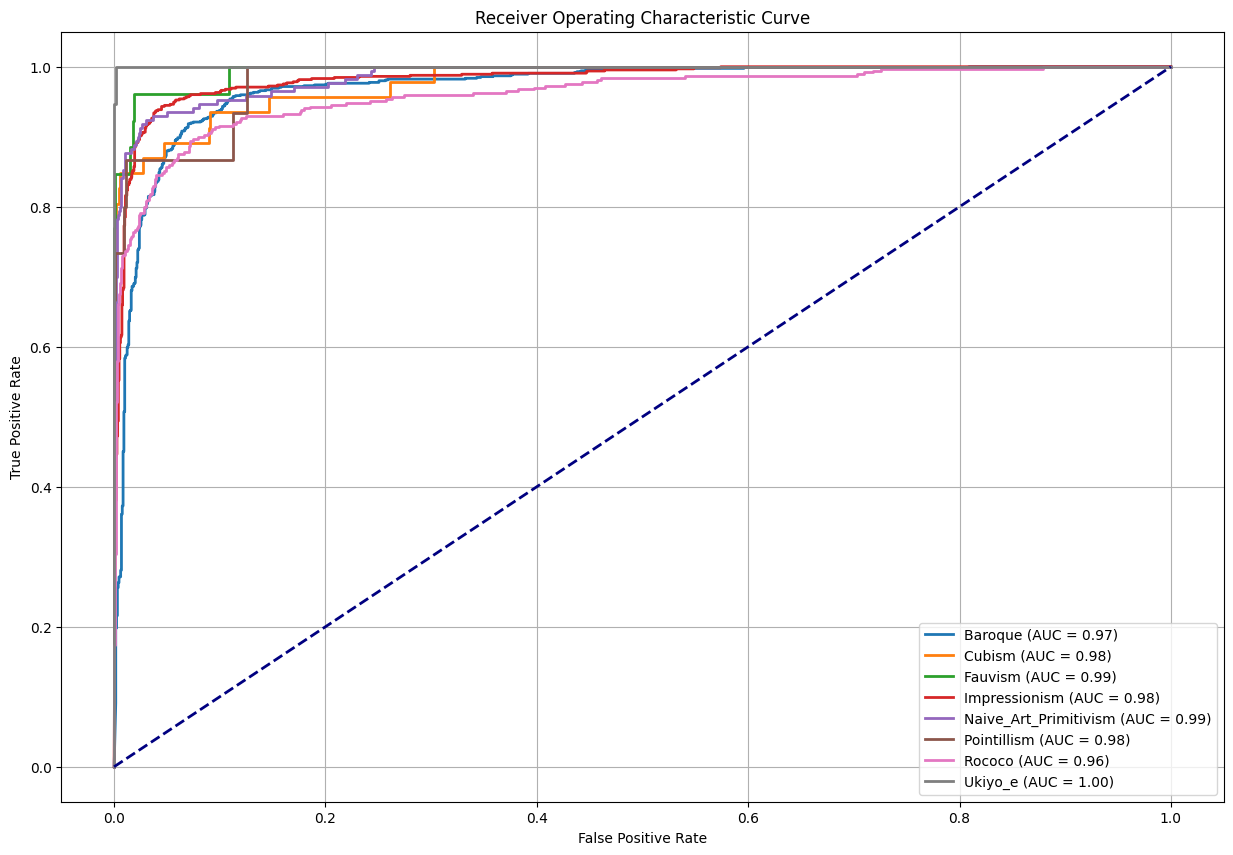

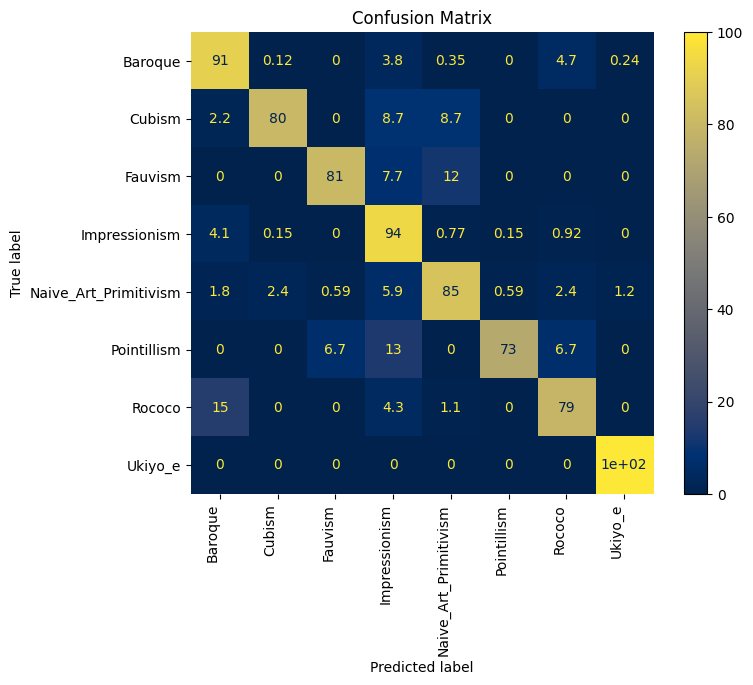

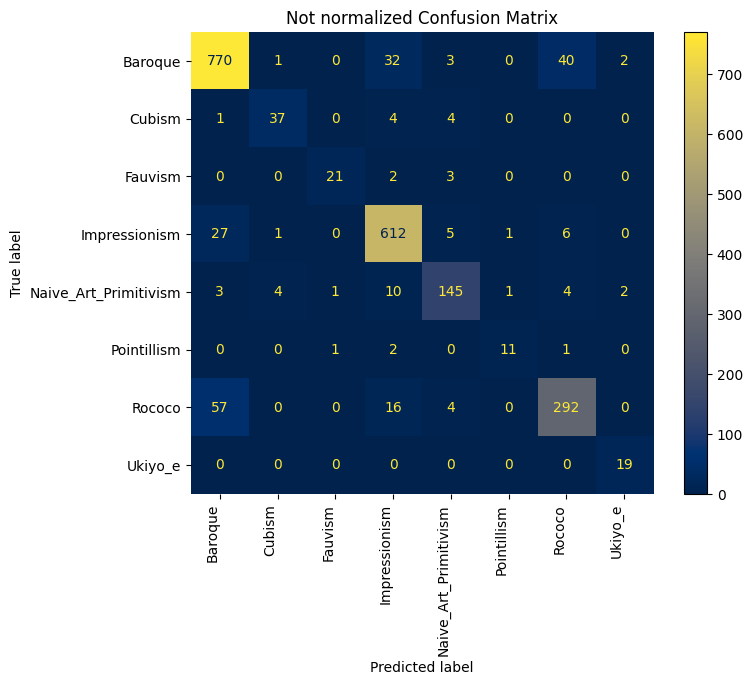

In [11]:
from sklearn.neural_network import MLPClassifier

best_mlp = MLPClassifier(
    hidden_layer_sizes=(490, 221, 116),
    solver="lbfgs",  
    learning_rate="adaptive",  
    learning_rate_init=0.0019296907971858555,  
    alpha=2.0617072079456476e-06, 
    batch_size=64, 
    activation="relu",  
    max_iter=303, 
    early_stopping=True,  
    random_state=42  
)
best_mlp.fit(X_train_scaled, y_train)
frmodel_pred = best_mlp.predict(X_test_scaled)
frmodel_pred_proba = best_mlp.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)



In [12]:
best_mlp = MLPClassifier(
    hidden_layer_sizes=(490, 221, 116),
    solver="lbfgs",  
    learning_rate="adaptive",  
    learning_rate_init=0.0019296907971858555,  
    alpha=2.0617072079456476e-06,  
    batch_size=64,  
    activation="relu", 
    max_iter=303,  
    early_stopping=True,  
    random_state=42  
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_mlp , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.903195  0.903030  0.902637  0.903030   19.047298   
1         2   0.911894  0.911888  0.911568  0.911888   22.515657   
2         3   0.908722  0.908159  0.908215  0.908159   19.698189   
3         4   0.909658  0.910023  0.909541  0.910023   21.344595   
4         5   0.914781  0.914646  0.914325  0.914646   20.702215   
5   Average   0.909650  0.909549  0.909257  0.909549   20.661591   
6  1.581139   0.004298  0.004362  0.004359  0.004362    1.363799   

   Prediction time  
0         0.019053  
1         0.011798  
2         0.017620  
3         0.047328  
4         0.015023  
5         0.022164  
6         0.014335  


In [13]:
from sklearn.svm import SVC
svc_model = SVC(
    kernel='poly', 
    C=39.55159458196473, 
    gamma=0.06924486730918748, 
    degree=3, 
    random_state=42
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  svc_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.916177  0.916084  0.915582  0.916084   16.410076   
1         2   0.915054  0.915152  0.914638  0.915152   17.938763   
2         3   0.912718  0.912354  0.911610  0.912354   17.707797   
3         4   0.915924  0.915152  0.914349  0.915152   17.292692   
4         5   0.924053  0.923507  0.922823  0.923507   17.880567   
5   Average   0.916785  0.916450  0.915800  0.916450   17.445979   
6  1.581139   0.004286  0.004186  0.004195  0.004186    0.631831   

   Prediction time  
0         2.155019  
1         1.981118  
2         2.178304  
3         1.969713  
4         2.043041  
5         2.065439  
6         0.096874  


/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                       precision    recall  f1-score      support
Baroque                 0.926887  0.894198  0.910249   879.000000
Cubism                  0.760870  0.875000  0.813953    40.000000
Fauvism                 0.846154  0.846154  0.846154    26.000000
Impressionism           0.932515  0.917044  0.924715   663.000000
Naive_Art_Primitivism   0.870588  0.919255  0.894260   161.000000
Pointillism             0.666667  1.000000  0.800000    10.000000
Rococo                  0.826558  0.878963  0.851955   347.000000
Ukiyo_e                 1.000000  1.000000  1.000000    19.000000
accuracy                0.901166  0.901166  0.901166     0.901166
macro avg               0.853780  0.916327  0.880161  2145.000000
weighted avg            0.903531  0.901166  0.901798  2145.000000
-----------------------------------------------------------------------------------------------------------


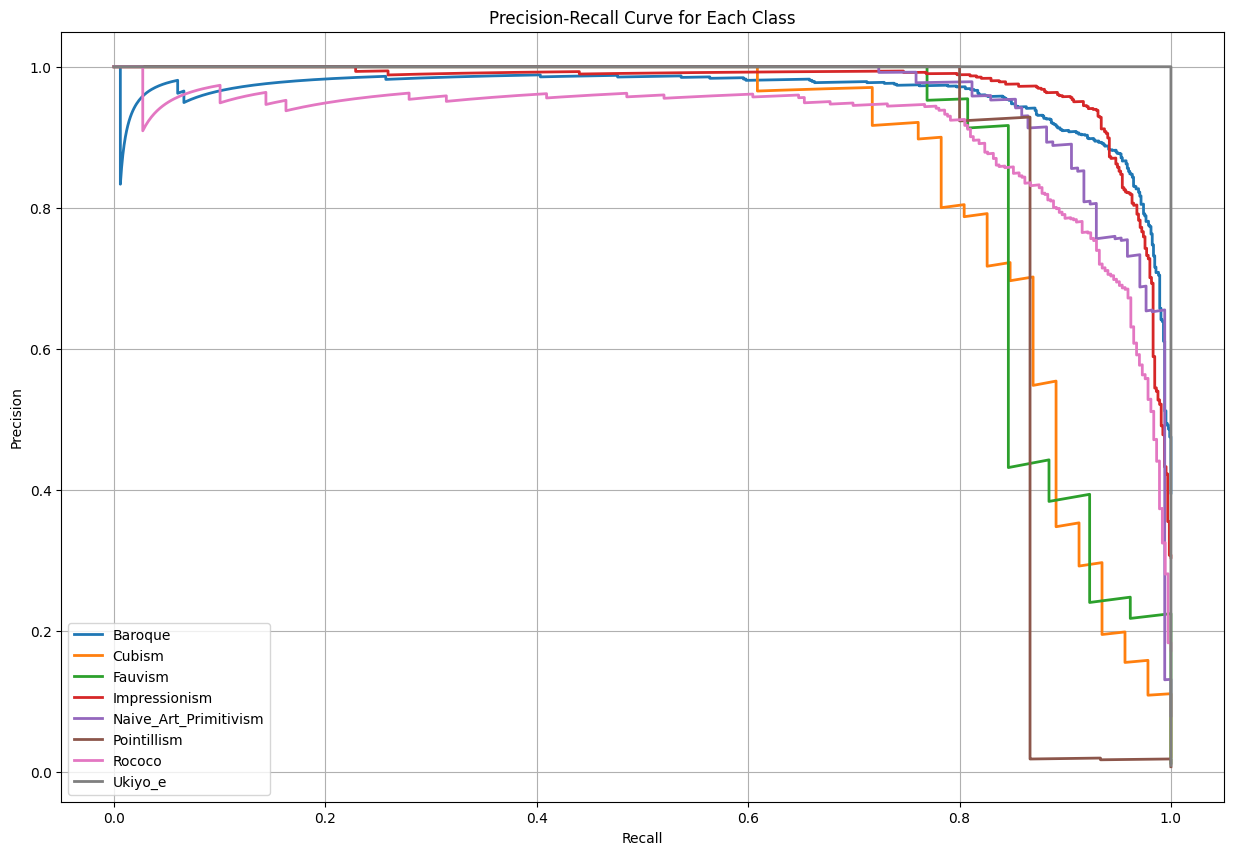

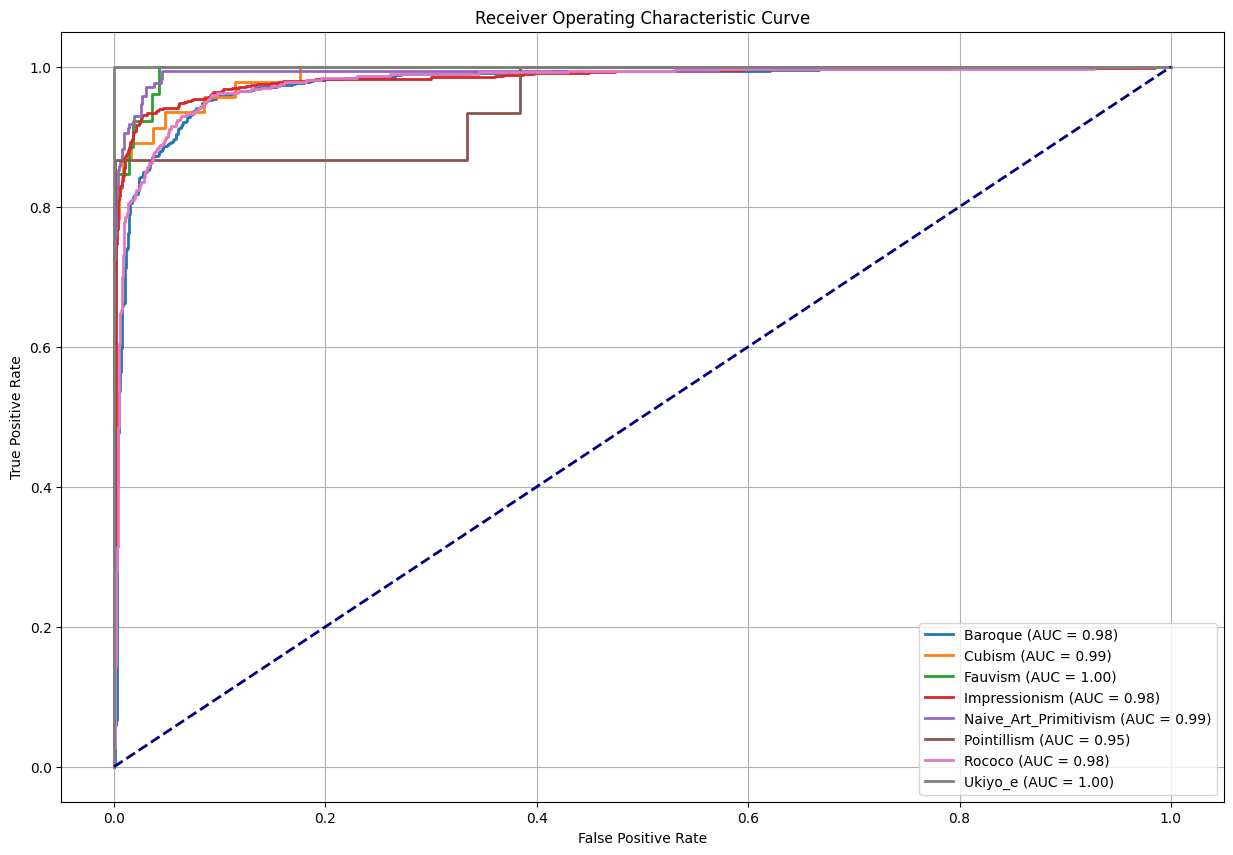

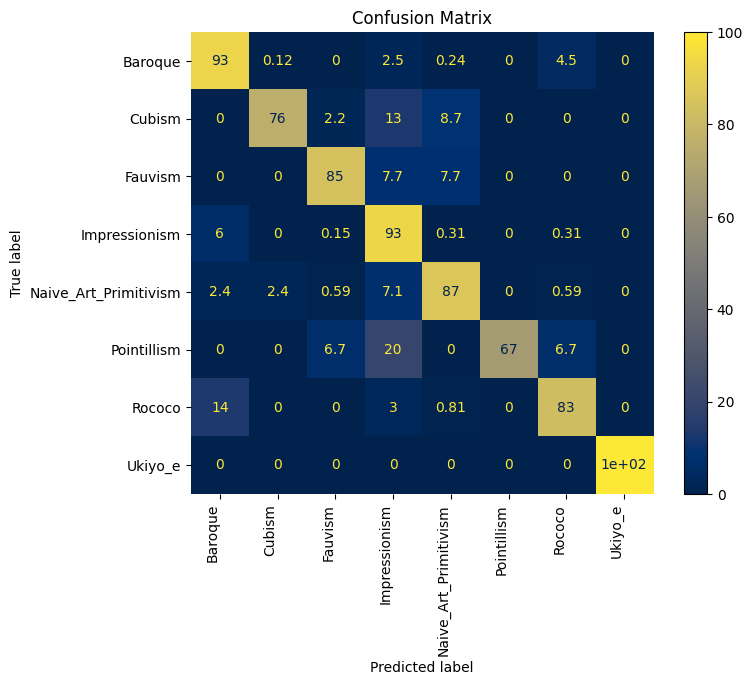

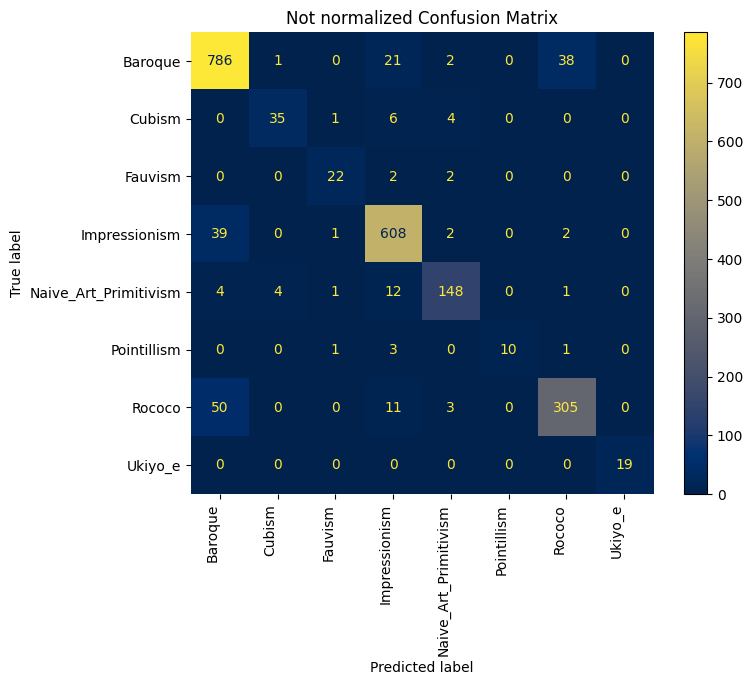

In [14]:
from sklearn.svm import SVC

svc_model = SVC(
    kernel='poly', 
    C=39.55159458196473, 
    gamma=0.06924486730918748, 
    degree=3, 
    random_state=42,
    probability = True
)

svc_model.fit(X_train_scaled, y_train)
frmodel_pred = svc_model.predict(X_test_scaled)
frmodel_pred_proba = svc_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [15]:
a = 0
a

0

/opt/conda/lib/python3.11/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                       precision    recall  f1-score      support
Baroque                 0.943396  0.851064  0.894855   940.000000
Cubism                  0.673913  0.968750  0.794872    32.000000
Fauvism                 0.807692  0.954545  0.875000    22.000000
Impressionism           0.924847  0.897321  0.910876   672.000000
Naive_Art_Primitivism   0.805882  0.944828  0.869841   145.000000
Pointillism             0.666667  1.000000  0.800000    10.000000
Rococo                  0.766938  0.924837  0.838519   306.000000
Ukiyo_e                 0.947368  1.000000  0.972973    18.000000
accuracy                0.887179  0.887179  0.887179     0.887179
macro avg               0.817088  0.942668  0.869617  2145.000000
weighted avg            0.896447  0.887179  0.888664  2145.000000
-----------------------------------------------------------------------------------------------------------


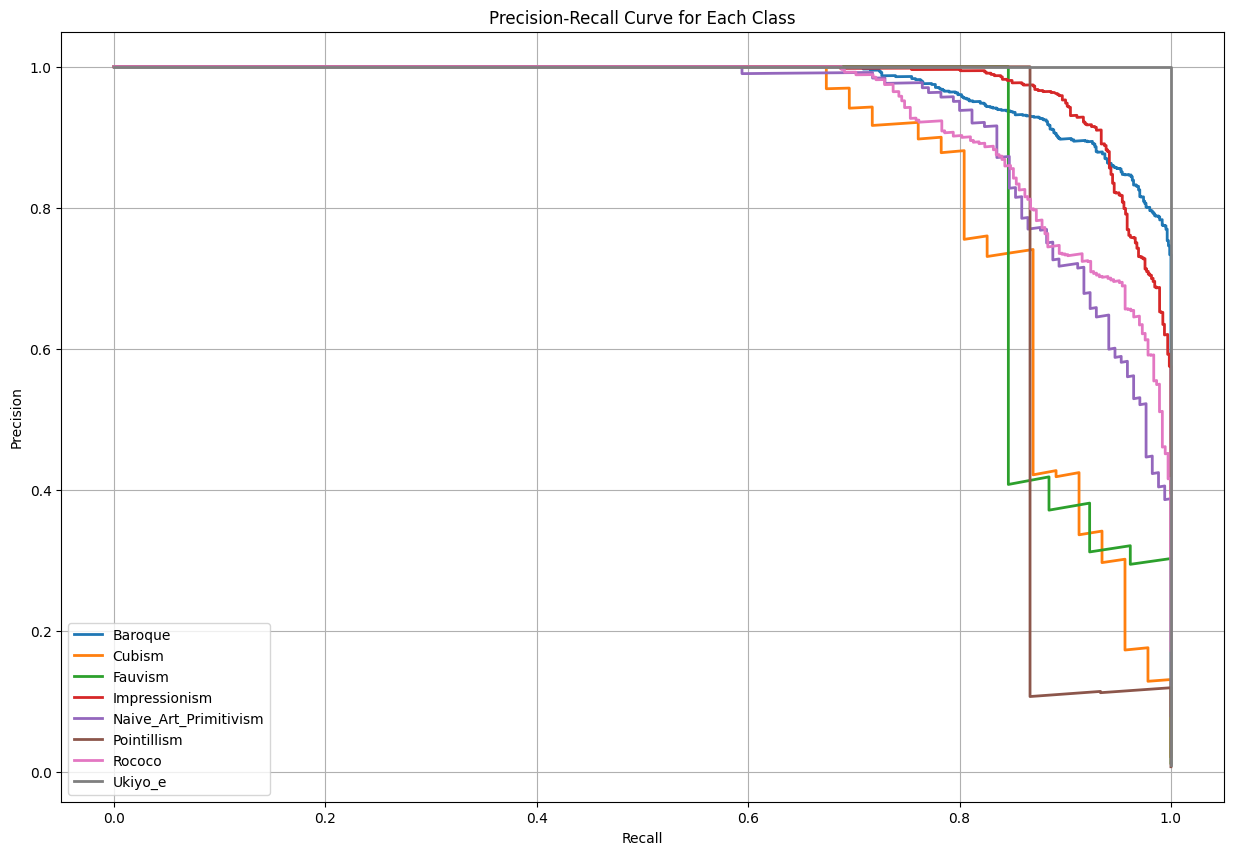

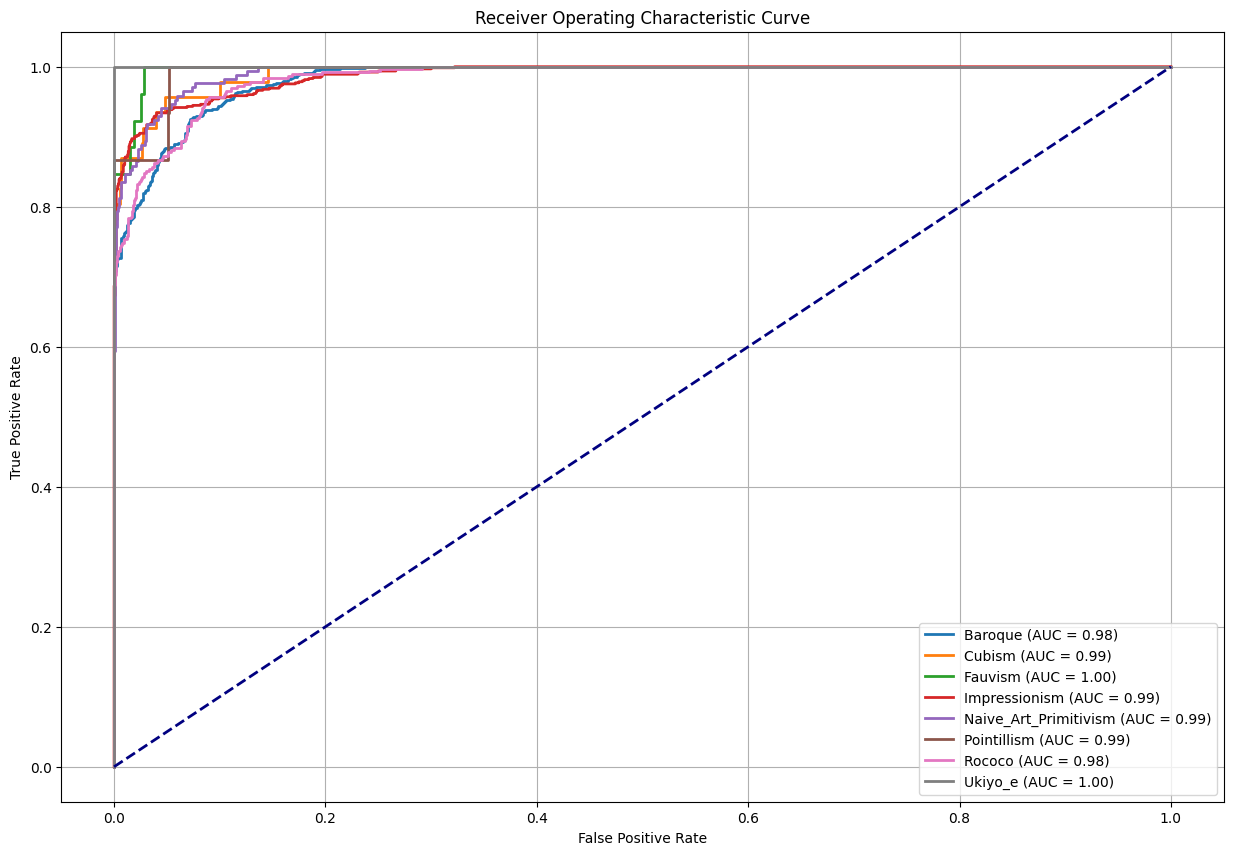

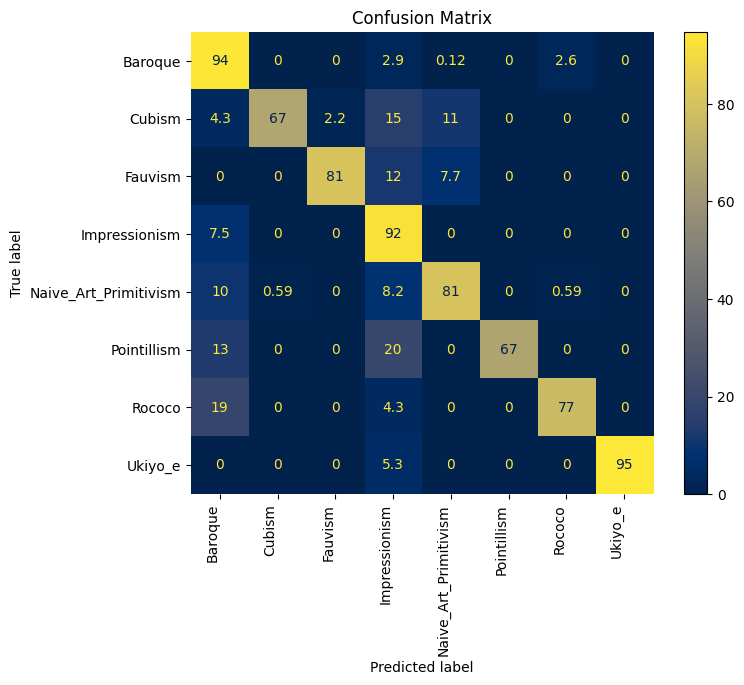

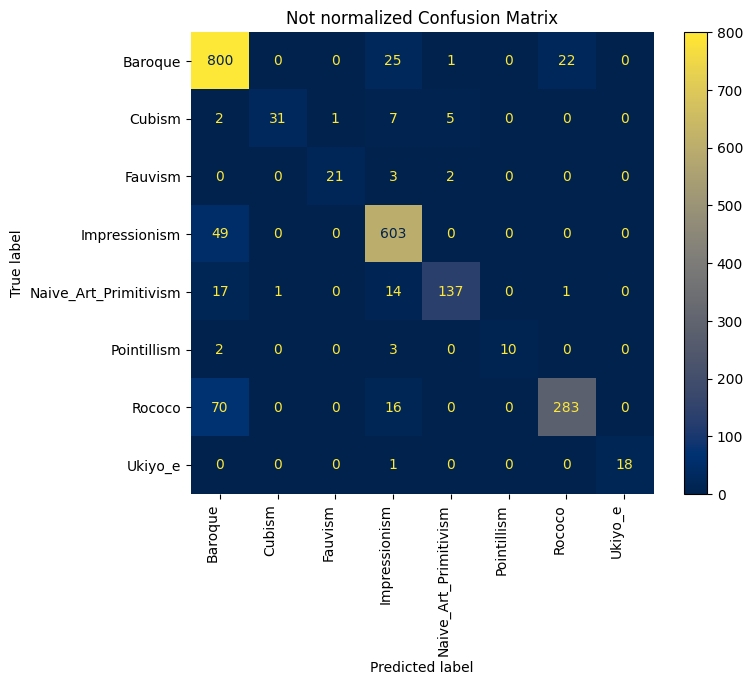

In [16]:
from sklearn.ensemble import RandomForestClassifier

best_rf = RandomForestClassifier(
    n_estimators=900,
    max_depth=20,
    min_samples_split=6,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=False,
    criterion='entropy',
    random_state=42,
    n_jobs=-1  # Use all cores for faster training
)

best_rf.fit(X_train_scaled, y_train)
frmodel_pred = best_rf.predict(X_test_scaled)
frmodel_pred_proba = best_rf.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [17]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_rf , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.904335  0.900699  0.899452  0.900699    8.792636   
1         2   0.898116  0.894172  0.892925  0.894172    9.117698   
2         3   0.893511  0.889044  0.887652  0.889044    8.734935   
3         4   0.898466  0.893706  0.891854  0.893706    8.811593   
4         5   0.910549  0.907183  0.905928  0.907183    9.527895   
5   Average   0.900995  0.896961  0.895562  0.896961    8.996951   
6  1.581139   0.006579  0.007062  0.007174  0.007062    0.332128   

   Prediction time  
0         0.242242  
1         0.224239  
2         0.220771  
3         0.282679  
4         0.231891  
5         0.240364  
6         0.025049  


/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:24:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                       precision    recall  f1-score      support
Baroque                 0.928066  0.891280  0.909301   883.000000
Cubism                  0.760870  0.945946  0.843373    37.000000
Fauvism                 0.769231  0.952381  0.851064    21.000000
Impressionism           0.937117  0.914671  0.925758   668.000000
Naive_Art_Primitivism   0.852941  0.906250  0.878788   160.000000
Pointillism             0.666667  1.000000  0.800000    10.000000
Rococo                  0.823848  0.876081  0.849162   347.000000
Ukiyo_e                 1.000000  1.000000  1.000000    19.000000
accuracy                0.900233  0.900233  0.900233     0.900233
macro avg               0.842342  0.935826  0.882181  2145.000000
weighted avg            0.903401  0.900233  0.901008  2145.000000
-----------------------------------------------------------------------------------------------------------


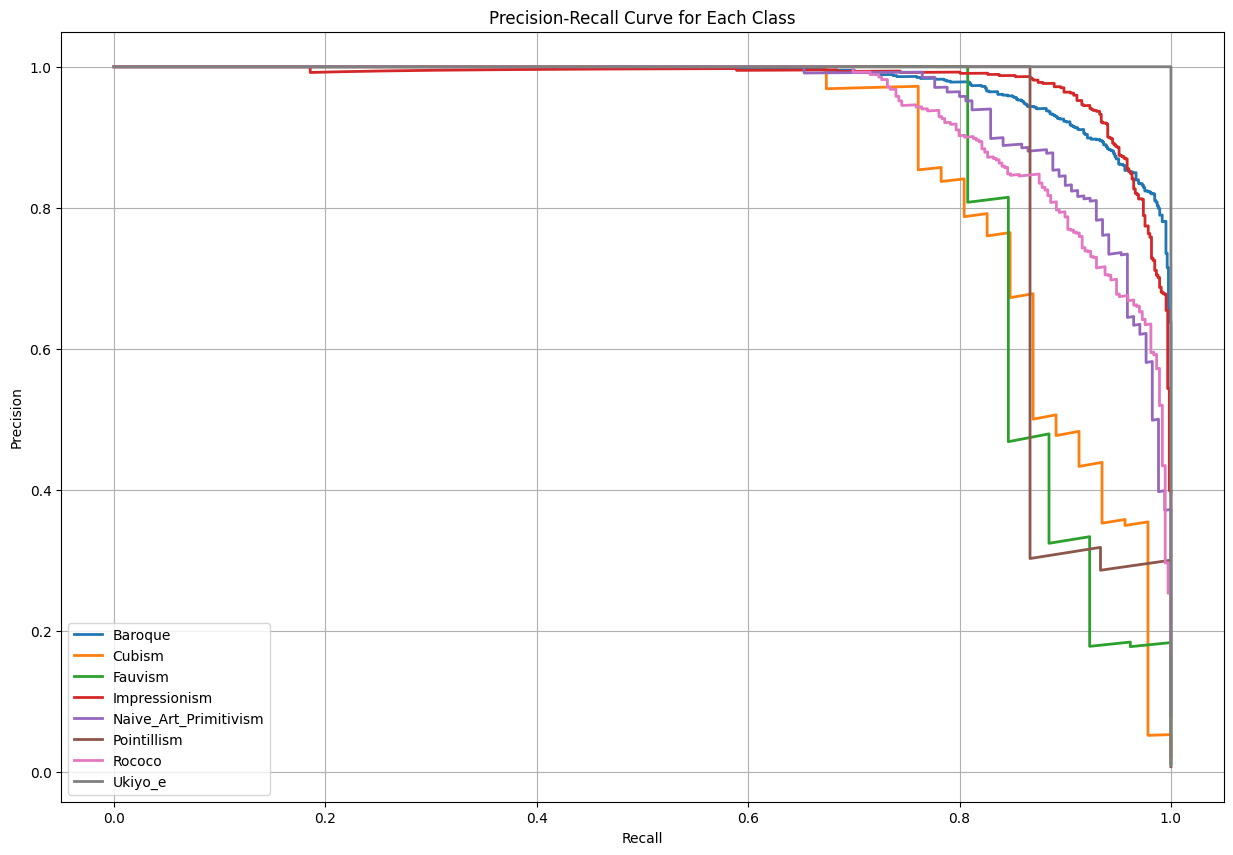

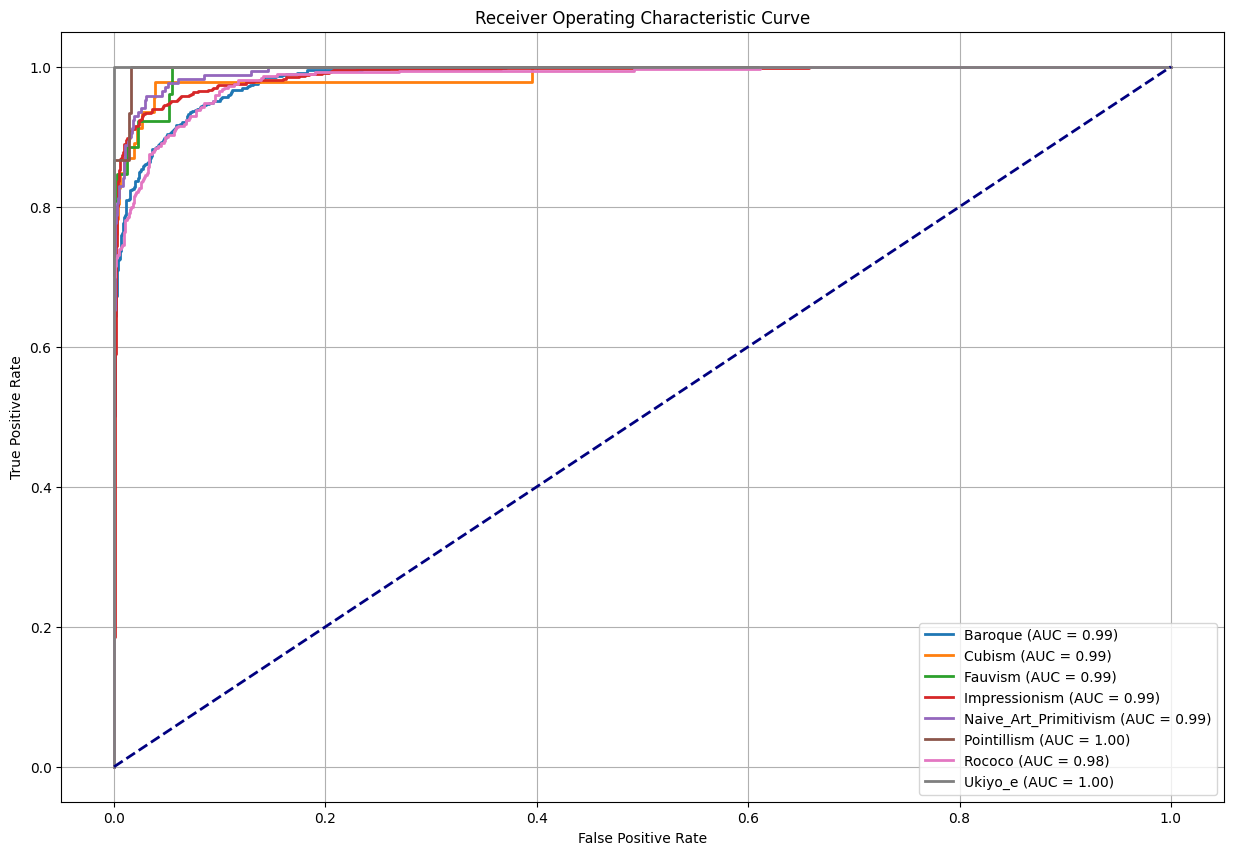

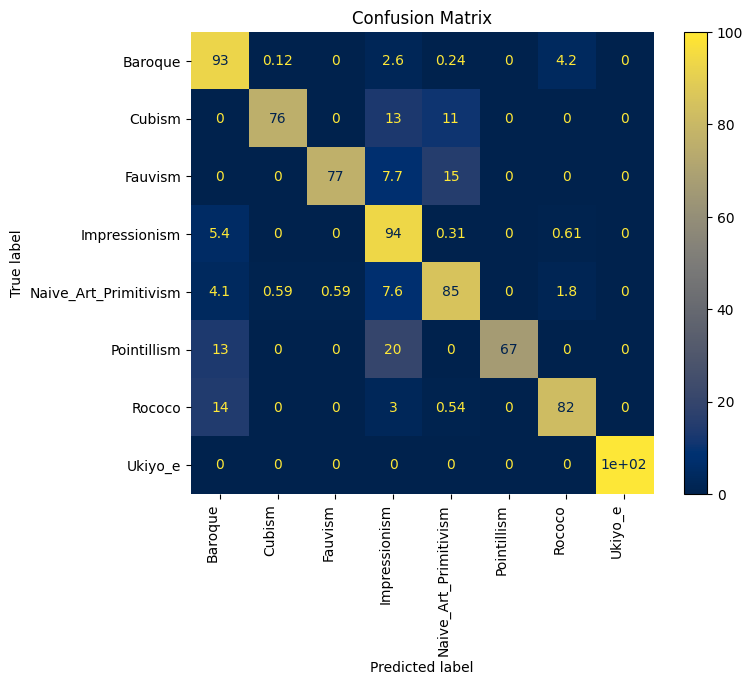

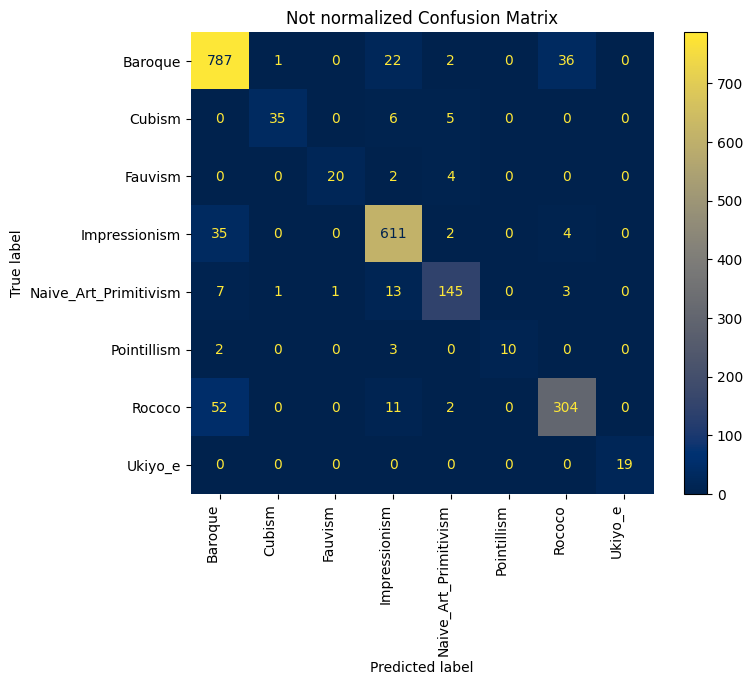

In [18]:
import xgboost as xgb

best_xgb = xgb.XGBClassifier(
    n_estimators=900,
    max_depth=4,
    learning_rate=0.17404904511951427,
    subsample=0.7846029675418292,
    colsample_bytree=0.7100830138794556,
    gamma=0.0264969818078781,
    reg_lambda=0.3460029118030738,
    reg_alpha=0.17069404218780862,
    objective='multi:softprob', 
    use_label_encoder=False,
    eval_metric='mlogloss',  
    random_state=42,
    n_jobs=-1
)

best_xgb.fit(X_train_scaled, y_train)
frmodel_pred = best_xgb.predict(X_test_scaled)
frmodel_pred_proba = best_xgb.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [19]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  best_xgb , 1)
print(avg)

/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:25:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:26:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:27:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:28:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:29:10] WARNING: /w

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.914731  0.914219  0.913554  0.914219   50.581840   
1         2   0.910436  0.910023  0.909181  0.910023   50.466889   
2         3   0.908694  0.908159  0.907387  0.908159   50.568414   
3         4   0.914093  0.913287  0.912218  0.913287   51.262100   
4         5   0.920473  0.919776  0.918689  0.919776   51.488699   
5   Average   0.913686  0.913093  0.912206  0.913093   50.873588   
6  1.581139   0.004550  0.004465  0.004365  0.004465    0.467160   

   Prediction time  
0         0.007059  
1         0.006767  
2         0.006917  
3         0.006871  
4         0.006875  
5         0.006898  
6         0.000106  


/opt/conda/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


                       precision    recall  f1-score      support
Baroque                 0.879717  0.889154  0.884410   839.000000
Cubism                  0.717391  0.891892  0.795181    37.000000
Fauvism                 0.807692  0.807692  0.807692    26.000000
Impressionism           0.889571  0.893683  0.891622   649.000000
Naive_Art_Primitivism   0.823529  0.858896  0.840841   163.000000
Pointillism             0.733333  0.916667  0.814815    12.000000
Rococo                  0.859079  0.800505  0.828758   396.000000
Ukiyo_e                 1.000000  0.826087  0.904762    23.000000
accuracy                0.870396  0.870396  0.870396     0.870396
macro avg               0.838789  0.860572  0.846010  2145.000000
weighted avg            0.871416  0.870396  0.870367  2145.000000
-----------------------------------------------------------------------------------------------------------


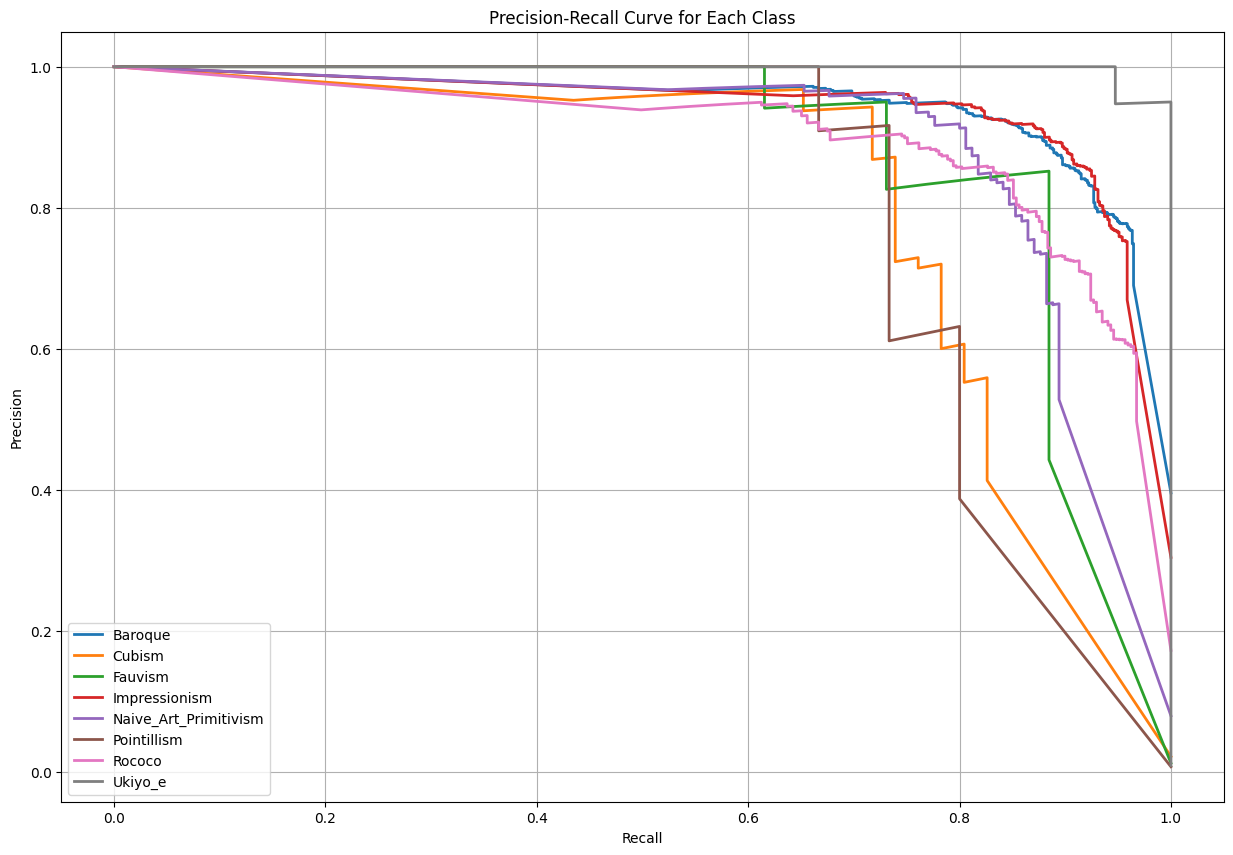

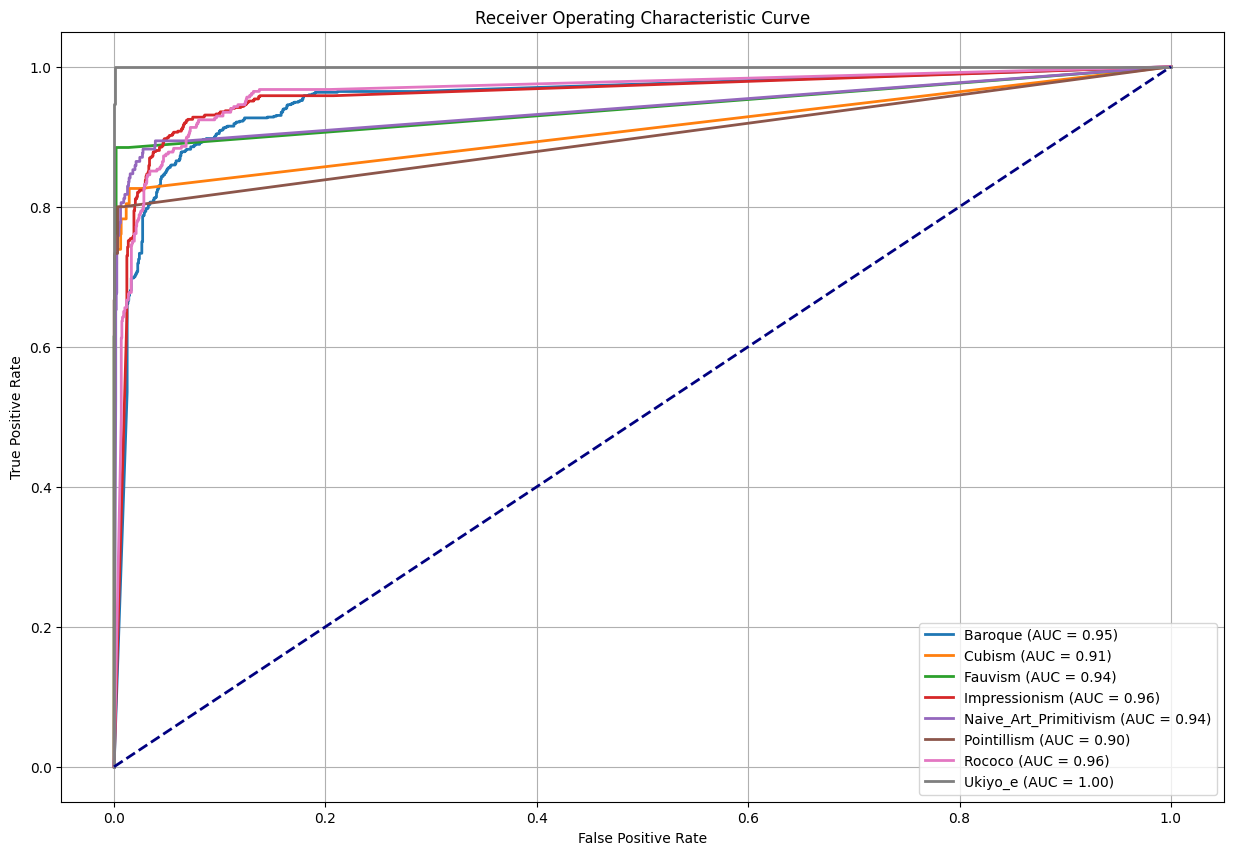

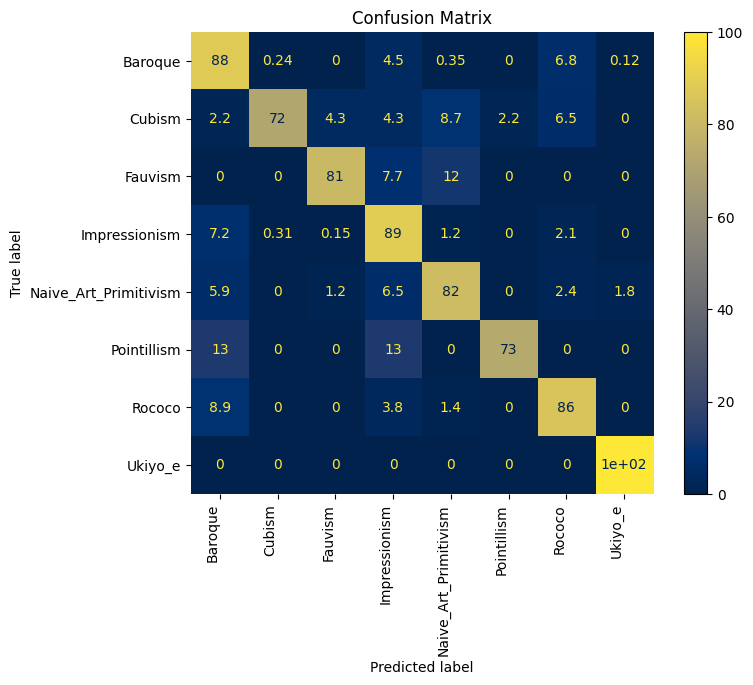

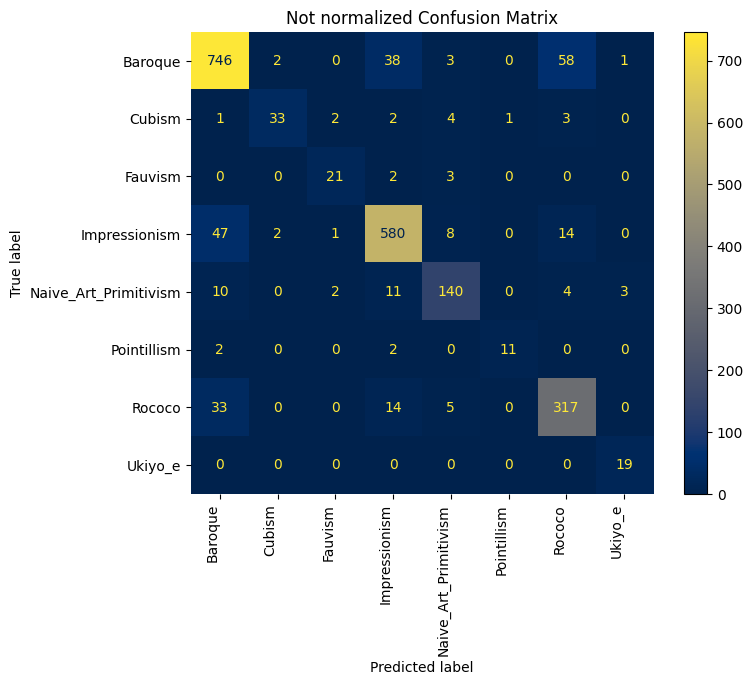

In [21]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    metric='cosine',
    algorithm='brute',
    n_neighbors=6,
    weights='distance',
    leaf_size=30,
    p=2  
)

knn_model.fit(X_train_scaled, y_train)
frmodel_pred = knn_model.predict(X_test_scaled)
frmodel_pred_proba = knn_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [23]:
knn_model = KNeighborsClassifier(
    metric='cosine',
    algorithm='brute',
    n_neighbors=6,
    weights='distance',
    leaf_size=30,
    p=2  
)


avg= e.kfold_crossvalidation(train_data, train_labels, 5,  knn_model , 1)
print(avg)
print("....")

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.881774  0.880653  0.880641  0.880653    0.012379   
1         2   0.888068  0.886247  0.886418  0.886247    0.013754   
2         3   0.890363  0.888578  0.888679  0.888578    0.013266   
3         4   0.888833  0.888112  0.888002  0.888112    0.012582   
4         5   0.886805  0.886660  0.886483  0.886660    0.013139   
5   Average   0.887169  0.886050  0.886045  0.886050    0.013024   
6  1.581139   0.003280  0.003170  0.003174  0.003170    0.000551   

   Prediction time  
0         0.283185  
1         0.280466  
2         0.286160  
3         0.280731  
4         0.279403  
5         0.281989  
6         0.002712  
....
